## Final Report

 - **Course**          : Introduction to Machine Learning and Data Mining
 - **Univerisity**     : DTU, Lyngby (Denmark)
 - **Dates**            : 5-9 March 2018
 - **Report deadline** : 19 March 2018
 - **Dataset**         : South Africa Heart Disease (available [here](https://web.stanford.edu/~hastie/ElemStatLearn/datasets/SAheart.data))


In [28]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd
import matplotlib.pyplot as plt

In [2]:
# Loading the data
data = pd.read_csv('data.csv')
data.head()

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


In [3]:
# data types
data.dtypes

row.names      int64
sbp            int64
tobacco      float64
ldl          float64
adiposity    float64
famhist       object
typea          int64
obesity      float64
alcohol      float64
age            int64
chd            int64
dtype: object

In [4]:
# Number of rows with missing values
len(data) - len(data.dropna())

0

In [5]:
data.describe()

,row.names,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd
count,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,231.935065,138.326840,3.635649,4.740325,25.406732,53.103896,26.044113,17.044394,42.816017,0.346320
std,133.938585,20.496317,4.593024,2.070909,7.780699,9.817534,4.213680,24.481059,14.608956,0.476313
min,1.000000,101.000000,0.000000,0.980000,6.740000,13.000000,14.700000,0.000000,15.000000,0.000000
25%,116.250000,124.000000,0.052500,3.282500,19.775000,47.000000,22.985000,0.510000,31.000000,0.000000
50%,231.500000,134.000000,2.000000,4.340000,26.115000,53.000000,25.805000,7.510000,45.000000,0.000000
75%,347.750000,148.000000,5.500000,5.790000,31.227500,60.000000,28.497500,23.892500,55.000000,1.000000
max,463.000000,218.000000,31.200000,15.330000,42.490000,78.000000,46.580000,147.190000,64.000000,1.000000


### After a quick inspection of the dataset, the following can be stated:


- **Main Problem of interest** : 

The main interest of this dataset is to predict if a certain patient has developed a coronary heart disease (binary prediction or likelihood via probability) based on a set of 9 attributes. So in essence, this is a classification problem.


- **Other use of the dataset when studying regression, clustering, association mining and anomaly detection**:
   - Regression: e.g predicting obesity as a function of sbp, tabacco, ldl, age, typea, adiposity and alcohol
   - Clustering: it could be interesting to look at the amount of clusters that can be formed by:
        - looking at the following attributes (or a subsample of these attributes): adiposity, age, alcohool and tabacco 
        - checking later if they correlate with a 2 or 3 obesity class (specified by range intervals of the obesity continous variable)
   - Association mining
   - Anomaly detection
   
   
- **Data Transformations**: 
  - famhist (family history of coronary heart disease) is a categorical nominal variable(Present /  Absent) so it should be converted to Binary in one single binary column [0,1].
  - Applying the describe() method shows that all data attributes (all columns expect of 'chd' and 'row.names') need to be standardized since the order of magnitude of some attrbutes are much larger than others (O(sbp) > O(tabacco))
  
  
- ** Attribute description**:
   - shp: discrete / ratio
   - tabacco: continuous / ratio
   - ldl: continuous / ratio
   - adiposity: continuous / ratio
   - famhist: binary / nominal
   - typea: discrete / interval
   - obesity: continuous / ratio
   - alcohol: continuous / ratio
   - age: discrete / ratio
   - chd: binary / nominal
   
   
- **Data issues**: No data issues have been identified (no missing values + no suspicious attribute min/max values)

In [6]:
def binarize(x):
    if x == 'Present':
        return 1
    else:
        return 0

data['famhist'] = data['famhist'].apply(lambda x: binarize(x))

In [10]:
# Define attribute names
attribute_names = [col for col in data.columns if col not in ['chd', 'row.names']]
array_data = np.asarray(data[attribute_names])

# Scale data using sklearn StandardScaler class (scale by sustracting attribute mean and normalizing by std)
scaler = StandardScaler()
scaler.fit(array_data)
array_data_tr = scaler.transform(array_data)
data_tr = pd.DataFrame(array_data_tr, columns=attribute_names)
data_tr['chd'] = data.loc[:,'chd']

# Sort by predictant values (y = 0,1)
data_tr.sort_values('chd', inplace=True)
data_tr.reset_index(inplace=True, drop=True)
data_tr.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1.156248,0.362758,1.551567,1.051593,1.185854,0.499251,2.379569,-0.360440,0.355234,0
1,0.228247,0.306089,0.057851,-0.233745,-0.843274,0.499251,-0.321709,0.068519,-0.055918,0
2,-0.309016,0.794314,-0.589909,-1.682485,-0.843274,0.703189,-1.559499,-0.612745,0.903437,0
3,0.277089,-0.269319,1.638580,1.312778,-0.843274,-0.724377,0.317379,-0.150254,1.177539,0
4,-0.504385,-0.225728,0.096524,-0.520663,-0.843274,0.805158,-1.127104,-0.696983,-0.809697,0


# PCA analysis

### Variance Explained
From the Variance explained plots shown below, it can be observed that in this dataset there is not much gained by performing a PCA since you tend to loose quite a lot of information if you just keep a few Principal components (i.e it can be seen in the cumulative sum plot that you need 7 out of 9 principal components to explain around 92% of the variance of the original dataset). On the other hand, the first principal component only explains roughly 33% of the variability of the original dataset. One could also state that these results reflect the fact that the original features are not very correlated between each other and a safe approach would be to keep them all for a later modelling analysis.

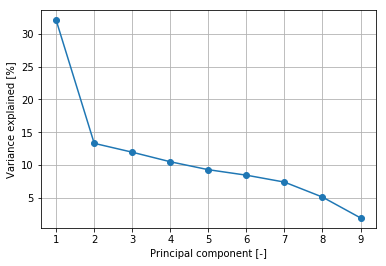

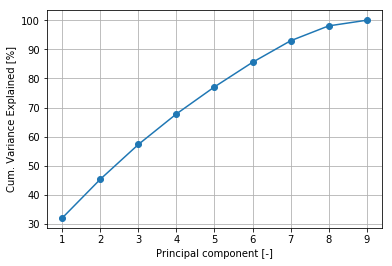

In [112]:
# Define matrix X containing 9 attributes correctly scaled
df_X = data_tr[attribute_names]
X = np.asarray(df_X)

# Perform singular value decomposition
U, S, V = svd(X, full_matrices=False)

# Variance explained
var_explained = S*S / np.sum(S*S)

# Plots of variable explained
plt.figure()
plt.plot(np.arange(1, len(var_explained) + 1), var_explained * 100., '-o')
plt.xlabel('Principal component [-]')
plt.ylabel('Variance explained [%]')
plt.grid()

plt.figure()
plt.plot(np.arange(1, len(var_explained) + 1), np.cumsum(var_explained * 100.), '-o')
plt.xlabel('Principal component [-]')
plt.ylabel('Cum. Variance Explained [%]')
plt.grid()

### Principal component directions

From the plots below, it can be seen that the predominant direction corresponds to:
 - a) The typeA feature for the first principal component
 - b) The famhist feature for the second principal component

It can be concluded that the typeA feature is the feature that explains most of the variance in the dataset. 

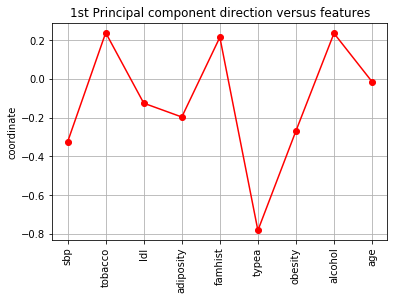

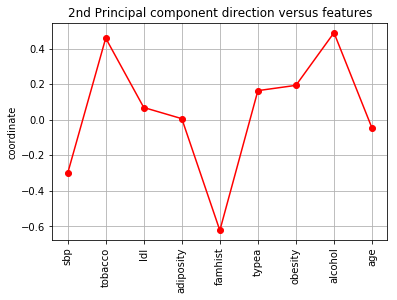

In [78]:
# The eigenvalue vectors or principal components are simply the columns of V, so we transpose V and get the rows.
Vt = V.T

plt.figure()
plt.title('1st Principal component direction versus features')
plt.plot(np.arange(1,len(Vt[0]) + 1), Vt[0], 'ro-')
plt.xticks(np.arange(1,len(Vt[0]) + 1), list(df_X.columns), rotation='vertical')
plt.ylabel('coordinate')
plt.grid()

plt.figure()
plt.title('2nd Principal component direction versus features')
plt.plot(np.arange(1,len(Vt[1]) + 1), Vt[1], 'ro-')
plt.xticks(np.arange(1,len(Vt[1]) + 1), list(df_X.columns), rotation='vertical')
plt.ylabel('coordinate')
plt.grid()

### Dataset projected into the first 2 principal components

The projected data can be computed by simply matrix multiplying the transpose of X with the first two eigenvectors of V respectively. We create two sets of X to account for the 2 existing classes.

It can be seen from the plot that:
 - a) as expected, PC1 shows most of the variability of the data (larger scatter in the x direction)
 - b) Both classes overlap quite a lot (difficult find a 'class splitting' rule from a first site)

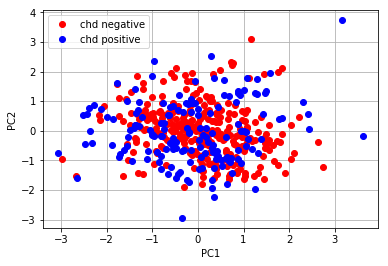

In [124]:
# For plotting purposes, we first create 2 np.ndarrays (X_neg and X_pos) each of them containing a 'chd' class
X_neg = np.asarray(data_tr[attribute_names][data_tr['chd'] == 0])
X_pos = np.asarray(data_tr[attribute_names][data_tr['chd'] == 1])

# 1st component projection
PC1_neg = np.asarray(np.matrix(X_neg) @ np.matrix(Vt[0]).T).flatten()
PC1_pos = np.asarray(np.matrix(X_pos) @ np.matrix(Vt[0]).T).flatten()

# 2nd component projection
PC2_neg = np.asarray(np.matrix(X_neg) @ np.matrix(Vt[1]).T).flatten()
PC2_pos = np.asarray(np.matrix(X_pos) @ np.matrix(Vt[1]).T).flatten()

plt.figure()
plt.plot(PC1_neg, PC2_neg, 'ro', label='chd negative')
plt.plot(PC1_pos, PC2_pos, 'bo', label='chd positive')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid()